In [3]:
"""\
# Copyright (C) 2024 Jesús Bautista Villar <jesbauti20@gmail.com>
"""
!python3 -V

Python 3.11.4


In [1]:
import numpy as np
from tqdm import tqdm

# Scalar field functions
from scalar_field.sigma_common import sigma
from scalar_field.sigma_funcs import sigma_gauss, sigma_nonconvex, sigma_fract

import matplotlib.pyplot as plt

# Main utility functions used along the notebook
from toolbox.math_utils import XY_distrib, gen_random_graph

## Centroid estimation

In [2]:
from scipy.integrate import odeint
from matplotlib.legend import Legend # legend artist

from toolbox.plot_utils import kw_def_patch, unicycle_patch


# ----------------------------------------------------------------------
# Utility functions
# ----------------------------------------------------------------------

def build_B(list_edges, n):
    B = np.zeros((n,len(list_edges)))
    for i in range(len(list_edges)):
        B[list_edges[i][0]-1, i] = 1
        B[list_edges[i][1]-1, i] = -1
    return B

def build_L_from_B(B):
    L = B@B.T
    return L

def dyn_centroid_estimation(xhat_0, t, Lb, x, k=1):
    xhat_dt = - k*(Lb.dot(xhat_0) - Lb.dot(x))
    return xhat_dt

# ----------------------------------------------------------------------
# Main function
# ----------------------------------------------------------------------

def plot_centroid_estimation(ax, X, Z, dt, tf, its=10, k=1,
                             legend=False, xlab=False, ylab=False):
    """
    Funtion that visualises the estimation of the centroid
    """
    N = X.shape[0]

    xc = np.sum(X, axis=0)/N
    xb = X.flatten()

    scale = np.max(np.linalg.norm(X-xc,axis=1))

    # Build the Laplacian matrix
    B = build_B(Z,N)
    L = build_L_from_B(B)
    Lb = np.kron(L, np.eye(2))

    # Compute algebraic connectivity (lambda_2)
    eig_vals = np.linalg.eigvals(L)
    min_eig_val = np.min(eig_vals[eig_vals > 0])

    # Simulation -------------------------------------------------------
    t_steps = int(tf/dt)
    t = np.linspace(0, t_steps, int(its*t_steps+1))
    
    xhat_0 = np.zeros_like(xb)
    xhat = odeint(dyn_centroid_estimation, xhat_0, t, args=(Lb,xb,k))

    xc_est0 = X
    xc_est = (xb - xhat[-1]).reshape(X.shape)
    # ------------------------------------------------------------------

    # -- Plotting --
    # Axis configuration
    ds = scale + scale/5
    ax.axis([xc[0]-ds, xc[0]+ds, xc[1]-ds, xc[1]+ds])
    ax.set_aspect("equal")
    ax.grid(True)

    title = r"$t_f$ = {0:.0f} ms, $f$ = {1:.1f} kHz".format(tf*1000, its/dt*tf) + "\n"
    title = title + r"$k$ = {0:.2f}, $\lambda_2$ = {1:.2f}".format(k, min_eig_val)
    ax.set_title(title)
    
    if xlab:
       ax.set_xlabel("$p_x$ [L]")
    if ylab:
        ax.set_ylabel("$p_y$ [L]")

    # Lines
    ax.axhline(0, c="k", ls="-", lw=1.1)
    ax.axvline(0, c="k", ls="-", lw=1.1)

    for edge in Z:
        ax.plot([X[edge[0]-1,0], X[edge[1]-1,0]], [X[edge[0]-1,1], X[edge[1]-1,1]], "k--", alpha=0.6)

    # Agents
    phi = np.pi/3
    for n in range(N):
        icon = unicycle_patch(X[n,:], phi, "royalblue", **kw_def_patch(scale))
        ax.add_patch(icon)

    # Points
    ax.scatter(xc[0], xc[1], c="k", marker=r"$x$", s=scale*100)
    ax.scatter(xc_est0[:,0], xc_est0[:,1], c="red", marker=r"$x$", alpha=0.4, s=scale*100)
    ax.scatter(xc_est[:,0], xc_est[:,1]  , c="red", marker=r"$x$", s=scale*100)


    # Generate the legend
    if legend:
        mrk1 = plt.scatter([],[],c='k'  ,marker=r'$x$',s=60)
        mrk2 = plt.scatter([],[],c='red',marker=r'$x$',s=60)

        leg = Legend(ax, [mrk1, mrk2], 
                    [r"$p_c$ (Non-computed)",
                    r"${p_{c}}^i$: Actual computed centroid from $i$"],
                    loc="upper left", prop={'size': 12}, ncol=1)

        ax.add_artist(leg)

### Some examples

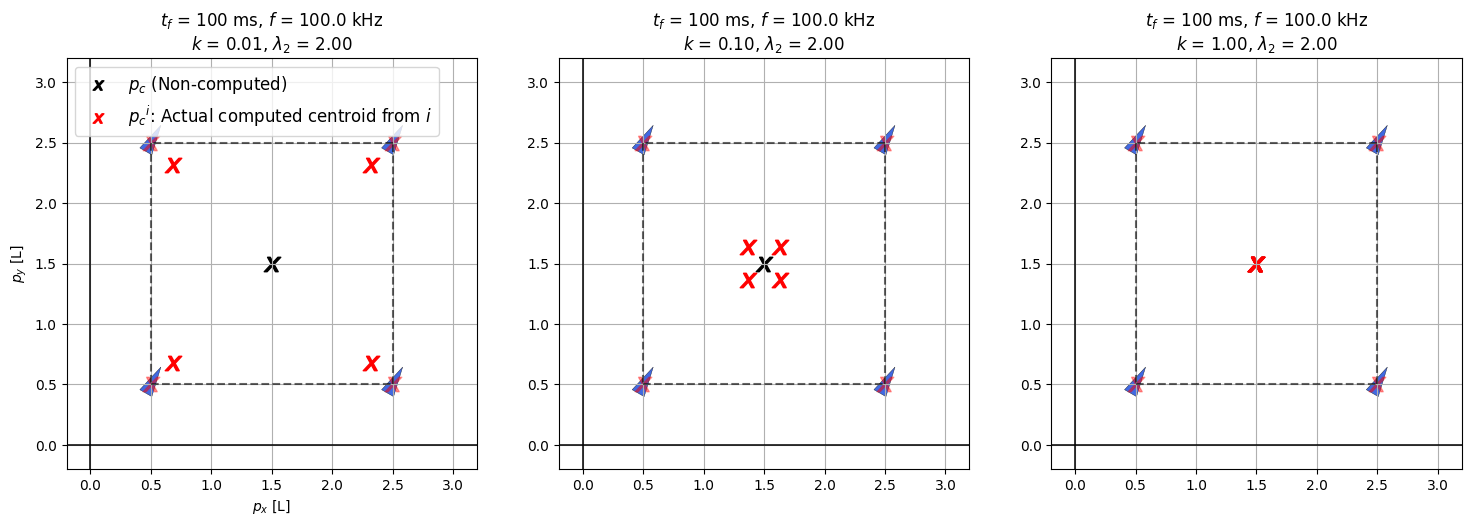

In [3]:
## Parameters #####
p = np.array([[1,1],[-1,1],[-1,-1],[1,-1]]) + np.array([1.5,1.5])
Z = ((1,2), (2,3), (3,4), (4,1))

dt = 0.01
its = 10 # iterations per dt

# ----------------------------------------------------------------------
# Plotting
# ----------------------------------------------------------------------

fig = plt.figure(figsize=(18, 10), dpi=100)
ax  = fig.subplots(1,3)

plot_centroid_estimation(ax[0], p, Z, dt=dt, tf=0.1, its=its, k=0.01, 
                         legend=True,xlab=True,ylab=True)
plot_centroid_estimation(ax[1], p, Z, dt=dt, tf=0.1, its=its, k=0.1)
plot_centroid_estimation(ax[2], p, Z, dt=dt, tf=0.1, its=its, k=1)

# Show the plot!
plt.show()

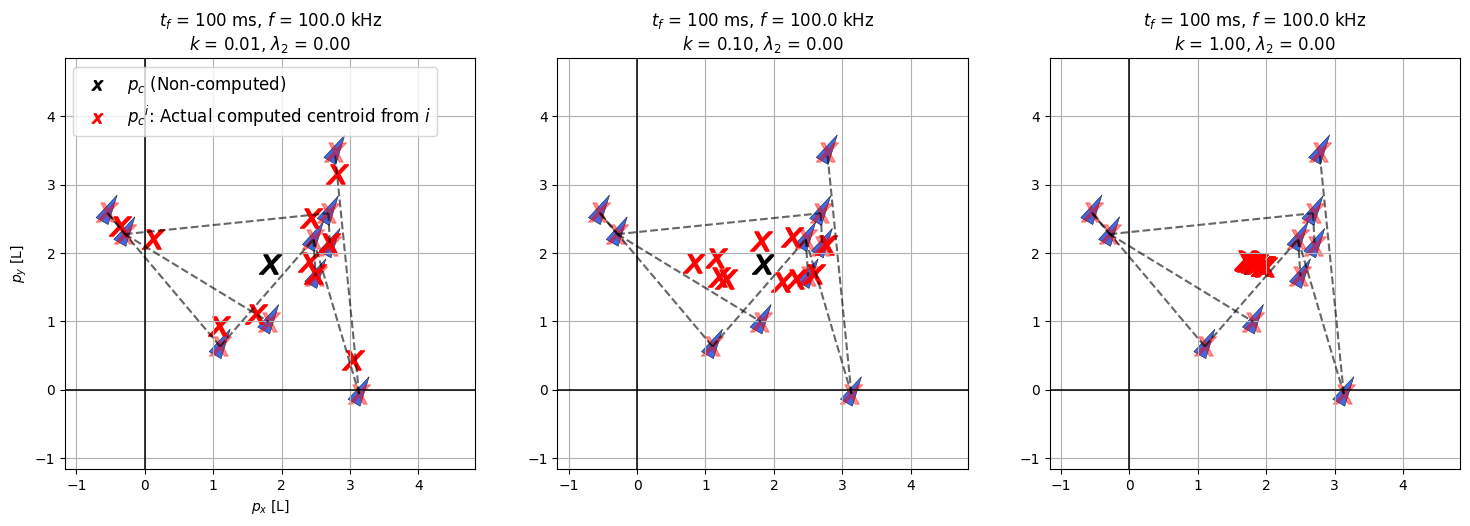

In [5]:
## Parameters #####
pc = np.array([1.2,1.5])
lims = np.array([2,2])

N = 10
p = XY_distrib(N,pc,lims)
Z = gen_random_graph(N)

dt = 0.01
its = 10 # iterations per dt

# ----------------------------------------------------------------------
# Plotting
# ----------------------------------------------------------------------

fig = plt.figure(figsize=(18, 10), dpi=100)
ax  = fig.subplots(1,3)

plot_centroid_estimation(ax[0], p, Z, dt=dt, tf=0.1, its=its, k=0.01, 
                         legend=True,xlab=True,ylab=True)
plot_centroid_estimation(ax[1], p, Z, dt=dt, tf=0.1, its=its, k=0.1)
plot_centroid_estimation(ax[2], p, Z, dt=dt, tf=0.1, its=its, k=1)

# Show the plot!
plt.show()

## Ascending direction estimation

In [6]:
from scipy.integrate import odeint
from matplotlib.legend import Legend # legend artist

from toolbox.plot_utils import kw_def_patch, kw_def_arrow, unicycle_patch, vector2d
from toolbox.math_utils import unit_vec, L_sigma

# ----------------------------------------------------------------------
# Utility functions
# ----------------------------------------------------------------------

def build_B(list_edges, n):
    B = np.zeros((n,len(list_edges)))
    for i in range(len(list_edges)):
        B[list_edges[i][0]-1, i] = 1
        B[list_edges[i][1]-1, i] = -1
    return B

def build_L_from_B(B):
    L = B@B.T
    return L

def dyn_mu_estimation(lhat, t, Lb, k=1):
    lhat_dt = - k*(Lb.dot(lhat))
    return lhat_dt

# ----------------------------------------------------------------------
# Main function
# ----------------------------------------------------------------------

def plot_mu_estimation(ax, P, Z, sigma_field, dt, tf, its=10, k=1,
                             legend=False, xlab=False, ylab=False):
    """
    Funtion that visualises the estimation of the ascending direction
    """
    N = P.shape[0]

    pc = np.sum(P, axis=0)/N
    pb = P.flatten()
    X = P - pc

    # Evaluate the scalar field and compute the L_sigma (the not estimated one)
    sigma_values = sigma_field.value(P)
    mu_i_comp = L_sigma(X, sigma_values)

    mu_i = sigma_values[:,None] * X
    mu_i_b = mu_i.flatten()

    # Build the Laplacian matrix
    B = build_B(Z,N)
    L = build_L_from_B(B)
    Lb = np.kron(L, np.eye(2))

    # Compute algebraic connectivity (lambda_2)
    eig_vals = np.linalg.eigvals(L)
    min_eig_val = np.min(eig_vals[abs(eig_vals) > 1e-7])

    # Simulation -------------------------------------------------------
    t_steps = int(tf/dt)
    t = np.linspace(0, t_steps, int(its*t_steps+1))
    
    lhat_0 = np.copy(mu_i_b)
    lhat = odeint(dyn_mu_estimation, lhat_0, t, args=(Lb,k))

    mu0 = mu_i
    mu = lhat[-1].reshape(P.shape)
    # ------------------------------------------------------------------

    # Plotting ---------------------------------------------------------
    # Axis configuration
    scale = np.max(np.linalg.norm(X, axis=1))
    arr_scale = 0.8
    ds = scale + 1

    ax.axis([pc[0]-ds, pc[0]+ds, pc[1]-ds, pc[1]+ds])
    ax.set_aspect("equal")
    ax.grid(True)

    title = r"$N$ = {0:d}, $t_f$ = {1:.0f} ms, $f$ = {2:.1f} kHz".format(N, tf*1000, its/dt*tf) + "\n"
    title = title + r"$k$ = {0:.2f}, $\lambda_2$ = {1:.2f}".format(k,min_eig_val)
    ax.set_title(title)
    
    if xlab:
       ax.set_xlabel("$p_x$ [L]")
    if ylab:
        ax.set_ylabel("$p_y$ [L]")

    # Lines
    ax.axhline(0, c="k", ls="-", lw=1.1)
    ax.axvline(0, c="k", ls="-", lw=1.1)

    alpha_edges = 0.8/(1+np.log(N))
    for edge in Z:
        ax.plot([P[edge[0]-1,0], P[edge[1]-1,0]], [P[edge[0]-1,1], P[edge[1]-1,1]], "k--", alpha=alpha_edges, zorder=-1)

    # Agents
    phi = np.pi/3
    for n in range(N):
        icon = unicycle_patch(P[n,:], phi, "royalblue", **kw_def_patch(scale))
        ax.add_patch(icon)

    # Points
    ax.scatter(pc[0], pc[1], c="k", marker=r"$x$", s=arr_scale*100)

    # Gradient arrow and computed ascending direction L1
    sigma_field.draw_grad(pc, ax, kw_def_arrow(arr_scale))
    vector2d(ax, pc, unit_vec(mu_i_comp), c="blue", alpha=0.7, **kw_def_arrow(arr_scale))

    # Estimated ascending direction mu
    for n in range(N):
        vector2d(ax, P[n,:], unit_vec(mu0[n,:]), c="red", alpha=0.3, **kw_def_arrow(arr_scale))
        vector2d(ax, P[n,:], unit_vec(mu[n,:]), c="red", alpha=0.9, **kw_def_arrow(arr_scale))
    
    # Generate the legend
    if legend:
        arr1 = plt.scatter([],[],c='k',marker=r'$\uparrow$',s=60)
        arr2 = plt.scatter([],[],c='red',marker=r'$\uparrow$',s=60)
        arr3 = plt.scatter([],[],c='blue',marker=r'$\uparrow$',s=60)

        leg = Legend(ax, [arr1, arr2, arr3], 
                    [r"$\nabla\sigma$ (Non-computed)",
                    r"$\mu_i$: Actual estimated ascending direction",
                    r"$L_1$: Actual computed ascending direction"],
                    loc="upper left", prop={'size': 8}, ncol=1)

        ax.add_artist(leg)

### Some examples

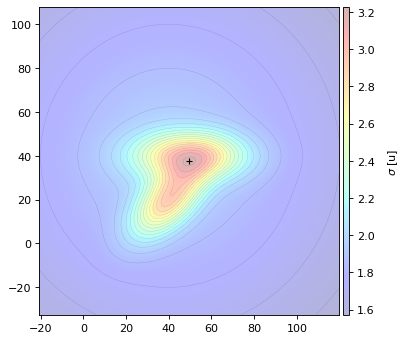

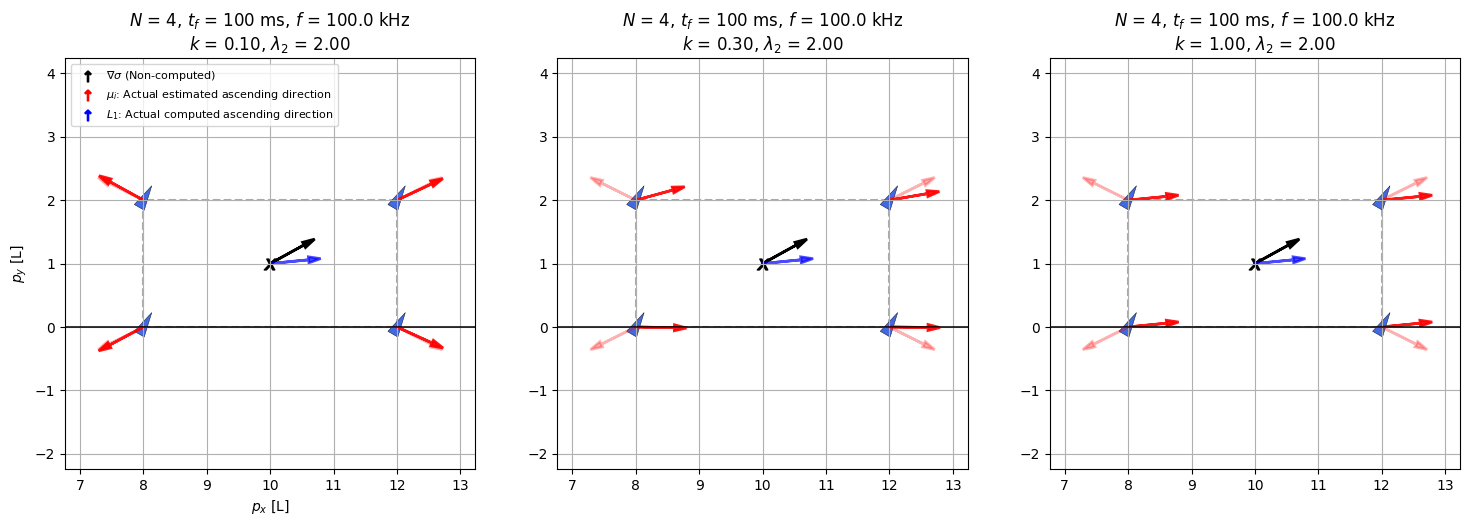

In [7]:
## Parameters #####
p = np.array([[2,1],[-2,1],[-2,-1],[2,-1]]) + np.array([10,1])
Z = ((1,2), (2,3), (3,4), (4,1))

dt = 0.01
its = 10 # iterations per dt

# ----------------------------------------------------------------------
# Generating the scalar field
# ----------------------------------------------------------------------
n = 2
max_int = 20
mu = [40,40]
dev = 10

sigma_func = sigma_nonconvex(k=0.04, dev=dev, mu=mu)
sigma_field = sigma(sigma_func)

# Draw the scalar field
fig = plt.figure(figsize=(5, 5), dpi=80)
ax = fig.subplots()
sigma_field.draw(fig=fig, ax=ax, xlim=70, ylim=70, contour_levels=20)

# ----------------------------------------------------------------------
# Plotting
# ----------------------------------------------------------------------

fig = plt.figure(figsize=(18, 10), dpi=100)
ax  = fig.subplots(1,3)

plot_mu_estimation(ax[0], p, Z, sigma_field, dt=dt, tf=0.1, its=its, k=0.1, 
                         legend=True,xlab=True,ylab=True)
plot_mu_estimation(ax[1], p, Z, sigma_field, dt=dt, tf=0.1, its=its, k=0.3)
plot_mu_estimation(ax[2], p, Z, sigma_field, dt=dt, tf=0.1, its=its, k=1)

# Show the plot!
plt.show()

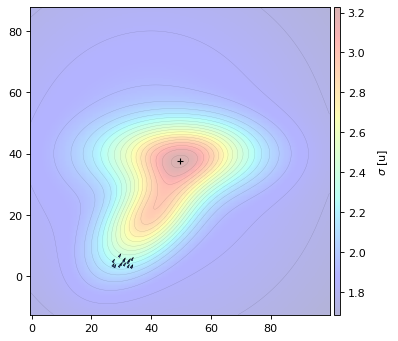

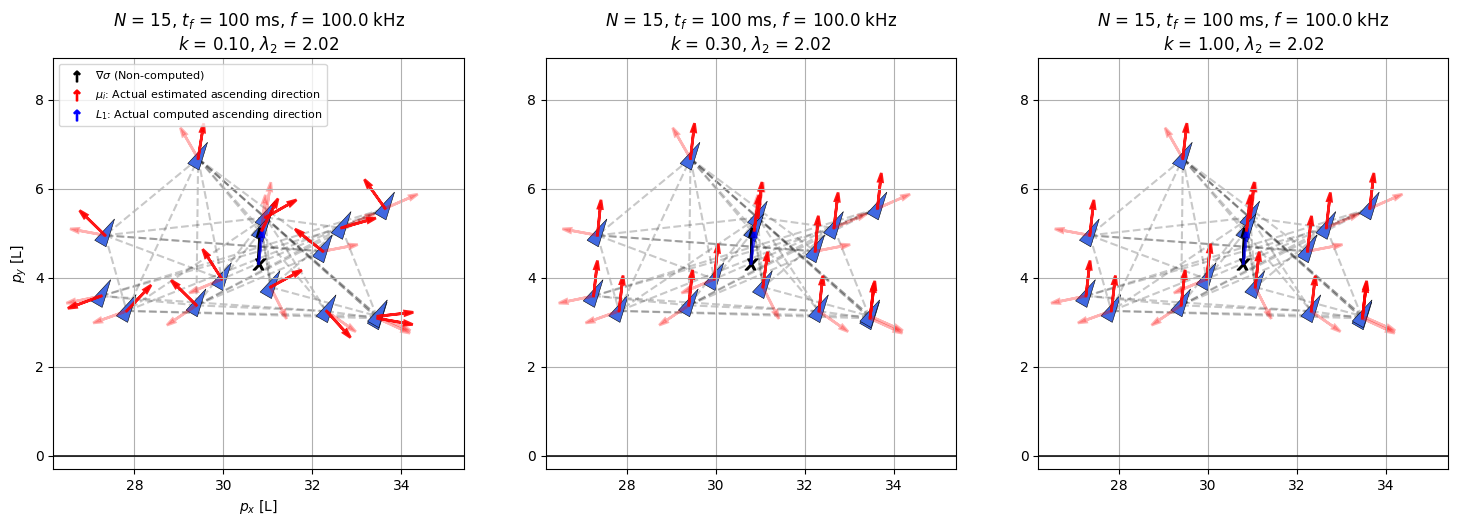

In [8]:
## Parameters #####
pc = np.array([30,5])
lims = np.array([4,2])

N = 15
p = XY_distrib(N,pc,lims)
Z = gen_random_graph(N, rounds=3)

dt = 0.01
its = 10 # iterations per dt

# ----------------------------------------------------------------------
# Generating the scalar field
# ----------------------------------------------------------------------
n = 2
max_int = 20
mu = [40,40]
dev = 10

sigma_func = sigma_nonconvex(k=0.04, dev=dev, mu=mu)
sigma_field = sigma(sigma_func)

# Draw the scalar field
fig = plt.figure(figsize=(5, 5), dpi=80)
ax = fig.subplots()
sigma_field.draw(fig=fig, ax=ax, xlim=50, ylim=50, contour_levels=20)

# Agents
phi = np.pi/3
for n in range(N):
    icon = unicycle_patch(p[n,:], phi, "royalblue")
    ax.add_patch(icon)

# ----------------------------------------------------------------------
# Plotting
# ----------------------------------------------------------------------

fig = plt.figure(figsize=(18, 10), dpi=100)
ax  = fig.subplots(1,3)

plot_mu_estimation(ax[0], p, Z, sigma_field, dt=dt, tf=0.1, its=its, k=0.1, 
                         legend=True,xlab=True,ylab=True)
plot_mu_estimation(ax[1], p, Z, sigma_field, dt=dt, tf=0.1, its=its, k=0.3)
plot_mu_estimation(ax[2], p, Z, sigma_field, dt=dt, tf=0.1, its=its, k=1)

# Show the plot!
plt.show()

## Centroid + ascending direction estimation

In [9]:
from simulator.simulator import simulator

### Some examples

In [10]:
## Parameters #####
pc = np.array([10,70])
lims = np.array([4,4])

N = 10
p = XY_distrib(N,pc,lims)
phi = np.random.rand(N) * np.pi
Z = gen_random_graph(N, rounds=3)

# ----------------------------------------------------------------------
# Generating the scalar field
# ----------------------------------------------------------------------
n = 2
max_int = 20
mu = [40,40]
dev = 10

sigma_func = sigma_nonconvex(k=0.04, dev=dev, mu=mu)
sigma_field = sigma(sigma_func)

In [11]:
# ----------------------------------------------------------------------
# Generating the simulator class
# ----------------------------------------------------------------------
dt = 1/60
q0 = [p, 2, phi]

sim = simulator(q0, Z, sigma_field, dt=dt, kc=1, kl=0.6, its_c=5, its_l=10)

# ----------------------------------------------------------------------
# Execute the simulation given a desired final time stamp
# ----------------------------------------------------------------------
tf = 40
its = int(tf/dt)

sim.restart()
for it in tqdm(range(its)):
    sim.int_step()

100%|██████████| 2400/2400 [00:02<00:00, 805.91it/s]


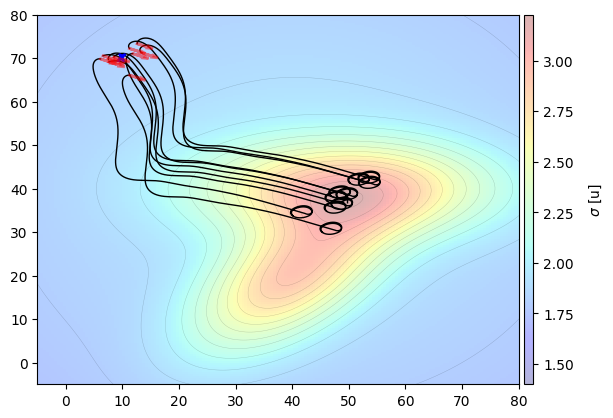

In [12]:
from toolbox.plot_utils import vector2d 

# -- Plot position during the whole simulation and estimations at t=0
kw_arr = {"s":1, "lw":2, "hw":0.5, "hl":1, "alpha":0.5}

# Collect data from the simulation
data_p = np.array(sim.data["p"])
data_pc_hat = np.array(sim.data["pc_hat"])
data_mu = np.array(sim.data["mu"])

fig = plt.figure()
ax = fig.subplots()

# Axes config
ax.set_xlim([-5,80])
ax.set_ylim([-5,80])

# Draw the scalar field
kw_draw_field = {"xlim":2*50, "ylim":2*50, "n":400, "contour_levels":20}
sim.sigma_field.draw(fig, ax, **kw_draw_field)

for n in range(N):
    # Position
    ax.plot(data_p[:,n,0], data_p[:,n,1], c="k", zorder=1, lw=1)

    # Estimated ascending direction mu
    li = 0
    vector2d(ax, data_p[li,n,:], data_mu[li,n,:]*3, c="red", **kw_arr, zorder=3)
    ax.scatter(data_pc_hat[li,n,0], data_pc_hat[li,n,1], c="b", marker=r"$x$", s=30)

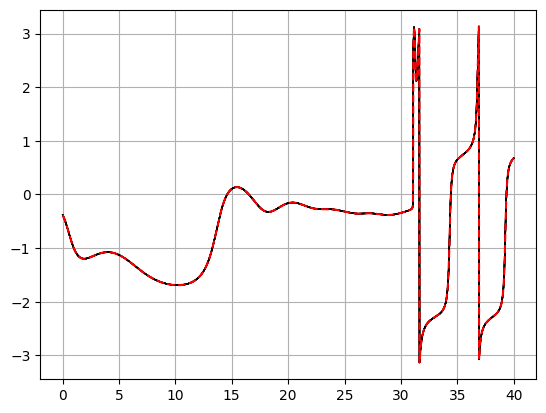

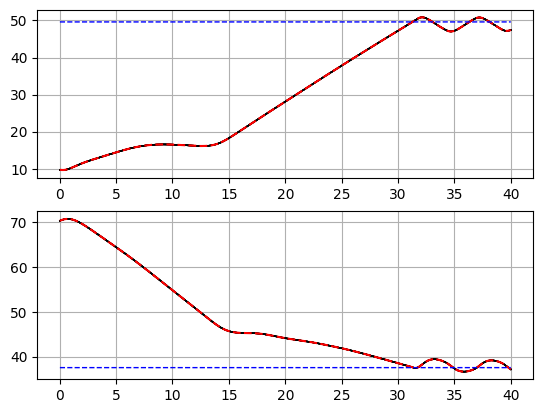

In [13]:
# -- Plot the estimations during the whole simulation
data_t = np.array(sim.data["t"])
data_pc_hat = np.array(sim.data["pc_hat"])
data_pc_comp = np.array(sim.data["pc_comp"])
data_p_sigma = sim.sigma_field.mu
data_mu = np.array(sim.data["mu"])
data_mu_comp = np.array(sim.data["mu_comp"])

psi_mu = np.arctan2(data_mu[:,:,1], data_mu[:,:,0])
psi_mu_comp = np.arctan2(data_mu_comp[:,1], data_mu_comp[:,0])

# mu estimation
fig = plt.figure()
ax = fig.subplots()
ax.grid(True)

ax.plot(data_t, psi_mu, c="k", alpha=0.7, lw=1)
ax.plot(data_t, psi_mu_comp, c="r", ls="--")

# centroid estimation
fig = plt.figure()
ax1, ax2 = fig.subplots(2,1)
ax1.grid(True)
ax2.grid(True)

ax1.plot(data_t,data_pc_hat[:,:,0], c="k", alpha=0.7, lw=1)
ax1.plot(data_t,data_pc_comp[:,0], c="r", ls="--")
ax1.plot(data_t, np.ones_like(data_t)*data_p_sigma[0], c="b", ls="--", lw=1)

ax2.plot(data_t,data_pc_hat[:,:,1], c="k", alpha=0.7, lw=1)
ax2.plot(data_t,data_pc_comp[:,1], c="r", ls="--")
ax2.plot(data_t, np.ones_like(data_t)*data_p_sigma[1], c="b", ls="--", lw=1)

plt.show()